In [1]:
# import necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = 'data'

In [4]:
# calculate euclidean distance
def euclidean_distance(x1, x2):
	return np.sqrt(np.sum((x1-x2)**2))

In [5]:
# visualize k vs accuracy plots
def visualize(res_lib, res_mod, title, k_min=2, k_max=51):

    plt.rcParams.update({'font.size': 18})

    fig = plt.figure(figsize=(8, 5))

    K = [k for k in range(k_min, k_max)]

    plt.plot(K, res_lib, '--', color='b', label='library')
    plt.plot(K, res_mod, color='r', label='modified')

    plt.title(title)
    plt.grid(True)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    # plt.legend()

## Off-the-shelf k-NN implementation

In [6]:
# classification with cross-validation with the sklearn implemenation of K-NN

def library_knn(X, y, k_min = 2, k_max = 51):

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # cv split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    res = []
    K = [k for k in range(k_min, k_max)]   

    # iterate over possible k's
    for k in K:

      scores = []

      # iterate over cv splits
      for train_index, val_index in kf.split(X_train):
          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N, M = X_train_cv.shape[0], X_train_cv.shape[1]

          # classification
          cls = KNeighborsClassifier(k)
          cls.fit(X_train_cv, y_train_cv)

          # evaluation
          score = cls.score(X_val_cv, y_val_cv)
          scores.append(score)

      # cv accuracy
      acc = sum(scores)/len(scores)
      res.append(acc)
      print("k = {} \t validation accuracy = {}".format(k, acc))

    # find the best k
    best_res = max(res)
    best_k = K[np.argmax(np.array(res))]

    # inference on the test set
    cls = KNeighborsClassifier(best_k)
    cls.fit(X_train, y_train)
    
    labels = cls.predict(X_test)
    test_score = accuracy_score(labels, y_test)

    print("\nBest k = {} \t best validation accuracy = {}\nTest accuracy = {}".format(best_k, best_res, test_score))

    return best_k, best_res, test_score, res

## Manual k-NN implementation

In [6]:
# classification of single test point

def find_knn_prediction(X_train, y_train, x_test, k):

  N = X_train.shape[0]

  distances = np.zeros((N, 2))

  # calculate distances to every training point
  i = 0
  for x_i in X_train:
    d = euclidean_distance(x_test, x_i)
    distances[i, 0] = i
    distances[i, 1] = d
    i += 1

  # sort the distances
  distances = distances[distances[:,1].argsort()]

  # save the indexes of k nearest neighbors
  nn_ind = []
  for j in range(k):
    nn_ind.append(int(distances[j,0]))

  # get the labels of k nearest neighbors
  nn_y = y_train[nn_ind]

  # prediction is the majory class
  classes, counts = np.unique(nn_y, return_counts = True)
  prediction_ind = np.argmax(counts)
  prediction = classes[prediction_ind]
  
  return prediction

In [7]:
# classification with cross-validation with the manual implemenation of K-NN

def manual_knn(X, y, k_min = 2, k_max = 51):

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # cv split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    K = [k for k in range(k_min, k_max)]
    res = []

    # iterate over possible k's
    for k in K:

      scores = []

      # iterate over cv splits
      for train_index, val_index in kf.split(X_train):
          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N = X_val_cv.shape[0]
          labels = np.zeros(N)

          # classification
          for i in range(N):
              labels[i] = find_knn_prediction(X_train_cv, y_train_cv, X_val_cv[i], k)

          # evaluation
          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      # cv accuracy
      acc = sum(scores)/len(scores)
      res.append(acc)
      print("k = {} \t validation accuracy = {}".format(k, acc))

    # find the best k
    best_res = max(res)
    best_k = K[np.argmax(np.array(res))]

    # inference on the test set
    N = X_test.shape[0]
    labels = np.zeros(N)

    for i in range(N):
        labels[i] = find_knn_prediction(X_train, y_train, X_test[i], best_k)

    test_score = accuracy_score(labels, y_test)

    print("\nBest k = {} \t best validation accuracy = {}\nTest accuracy = {}".format(best_k, best_res, test_score))

    return best_k, best_res, test_score, res

## Modified k-NN implementation

In [7]:
# at the training stage calculate probabilities

def calculate_p_i(X_train, y_train, l=5):

    N = X_train.shape[0]

    distances = np.zeros((N, 2))
    P = np.zeros(N)

    # iterate over all training points
    for i in range(N):
        # calculate distance to everty other training point
        for j in range(N):  
            if i != j:
                d = euclidean_distance(X_train[i], X_train[j])
                distances[j, 0] = j
                distances[j, 1] = d

        # sort the distances
        distances = distances[distances[:,1].argsort()]

        # save the indexes of k nearest neighbors
        knn_ind = []
        for j in range(l):
            knn_ind.append(int(distances[j,0]))

        # get the labels of k nearest neighbors
        knn_labels = y_train[knn_ind]

        # calculate occureces of labels of k nearest neighbors
        values, counts = np.unique(knn_labels, return_counts=True)
        values = np.array(values)

        # indices of the same-class neighbors
        ind = np.where(values == y_train[i])[0]

        if ind.size == 0:
            P[i] = 1 / (len(knn_ind) + 1)
        else:
            index = int(ind[0])
            my_class_counts = counts[index]
            P[i] = (1 + my_class_counts) / (len(knn_ind) + 1)

    return P

In [8]:
# classification of single test point

def modified_knn_prediction(X_train, y_train, x_test, P, k, t=0.7):

  N = X_train.shape[0]

  distances = np.zeros((N, 2))

  # calculate distances to every training point
  i = 0
  for x_i in X_train:
    d = euclidean_distance(x_test, x_i)
    distances[i, 0] = i
    distances[i, 1] = d
    i += 1

  # sort the distances
  distances = distances[distances[:,1].argsort()]

  # get the index of the nearest neighbor (NN)
  nn_ind = int(distances[0, 0])

  # if the NN has high probability, get its class
  if P[nn_ind] >= t:
      return y_train[nn_ind]

  # if the NN has mixed neighbors, persorm KNN with adaptive distance
  else:

      # calculate new distances
      distances[:, 1] = distances[:, 1] / P
      distances = distances[distances[:,1].argsort()]

      # save the indexes of k nearest neighbors
      knn_ind = []
      for j in range(k):
          knn_ind.append(int(distances[j,0]))

      # get the labels of k nearest neighbors
      knn_labels = y_train[knn_ind]

      # prediction is majority class
      classes, counts = np.unique(knn_labels, return_counts = True)
      prediction_ind = np.argmax(counts)
      prediction = classes[prediction_ind]
      
      return prediction

In [9]:
# classification with cross-validation with the manual implemenation of K-NN

def modified_knn(X, y, k_min=2, k_max = 51, t=0.7, l=5):

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # cv split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    K = [k for k in range(k_min, k_max)]
    res = []

    # iterate over possible k's
    for k in K:

      scores = []

      # iterate over cv splits
      for train_index, val_index in kf.split(X_train):
          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          # classification
          P = calculate_p_i(X_train_cv, y_train_cv, l=l)

          N = X_val_cv.shape[0]
          labels = np.zeros(N)

          for i in range(N):
              labels[i] = modified_knn_prediction(X_train_cv, y_train_cv, X_val_cv[i], P, k, t=t)

          # evaluation
          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      # cv accuracy
      acc = sum(scores)/len(scores)
      res.append(acc)
      print("k = {} \t validation accuracy = {}".format(k, acc))

    # find the best k
    best_res = max(res)
    best_k = K[np.argmax(np.array(res))]

    # inference on the test set
    P = calculate_p_i(X_train, y_train, l=l)

    N = X_test.shape[0]
    labels = np.zeros(N)

    for i in range(N):
        labels[i] = modified_knn_prediction(X_train, y_train, X_test[i], P, best_k, t=t)

    test_score = accuracy_score(labels, y_test)

    print("\nBest k = {} \t best validation accuracy = {}\nTest accuracy = {}".format(best_k, best_res, test_score))
    return best_k, best_res, test_score, res

## Evaluation

### Iris

In [33]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((150, 4), (150,))

Text(0.5, 1.0, 'Iris PCA')

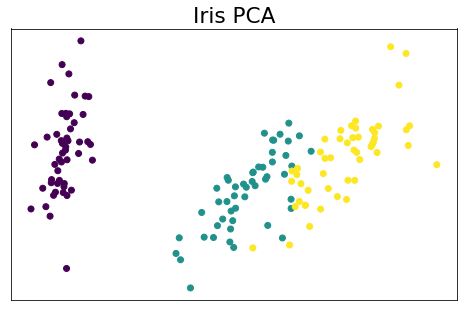

In [17]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 5))
plt.xticks([])
plt.yticks([])

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], c=y)

plt.title("Iris PCA")

In [18]:
best_k_lib_iris, best_res_lib_iris, test_score_lib_iris, res_lib_iris = library_knn(X, y)

k = 2 	 validation accuracy = 0.925
k = 3 	 validation accuracy = 0.9333333333333332
k = 4 	 validation accuracy = 0.95
k = 5 	 validation accuracy = 0.95
k = 6 	 validation accuracy = 0.95
k = 7 	 validation accuracy = 0.95
k = 8 	 validation accuracy = 0.95
k = 9 	 validation accuracy = 0.95
k = 10 	 validation accuracy = 0.95
k = 11 	 validation accuracy = 0.9416666666666667
k = 12 	 validation accuracy = 0.9416666666666667
k = 13 	 validation accuracy = 0.9416666666666667
k = 14 	 validation accuracy = 0.95
k = 15 	 validation accuracy = 0.9416666666666668
k = 16 	 validation accuracy = 0.9416666666666668
k = 17 	 validation accuracy = 0.9416666666666668
k = 18 	 validation accuracy = 0.9333333333333333
k = 19 	 validation accuracy = 0.9333333333333333
k = 20 	 validation accuracy = 0.9333333333333333
k = 21 	 validation accuracy = 0.9333333333333333
k = 22 	 validation accuracy = 0.9333333333333333
k = 23 	 validation accuracy = 0.95
k = 24 	 validation accuracy = 0.95
k = 25 	 va

In [20]:
best_k_m_iris, best_res_m_iris, test_score_m_iris, res_m_iris = manual_knn(X, y)

k = 2 	 validation accuracy = 0.925
k = 3 	 validation accuracy = 0.9333333333333332
k = 4 	 validation accuracy = 0.95
k = 5 	 validation accuracy = 0.95
k = 6 	 validation accuracy = 0.95
k = 7 	 validation accuracy = 0.95
k = 8 	 validation accuracy = 0.95
k = 9 	 validation accuracy = 0.95
k = 10 	 validation accuracy = 0.95
k = 11 	 validation accuracy = 0.9416666666666667
k = 12 	 validation accuracy = 0.9416666666666667
k = 13 	 validation accuracy = 0.9416666666666667
k = 14 	 validation accuracy = 0.95
k = 15 	 validation accuracy = 0.9416666666666668
k = 16 	 validation accuracy = 0.9416666666666668
k = 17 	 validation accuracy = 0.9416666666666668
k = 18 	 validation accuracy = 0.9333333333333333
k = 19 	 validation accuracy = 0.9333333333333333
k = 20 	 validation accuracy = 0.9333333333333333
k = 21 	 validation accuracy = 0.9333333333333333
k = 22 	 validation accuracy = 0.9333333333333333
k = 23 	 validation accuracy = 0.95
k = 24 	 validation accuracy = 0.95
k = 25 	 va

In [34]:
best_k_mod_iris, best_res_mod_iris, test_score_mod_iris, res_mod_iris = modified_knn(X, y)

k = 2 	 validation accuracy = 0.9333333333333332
k = 3 	 validation accuracy = 0.9416666666666667
k = 4 	 validation accuracy = 0.9416666666666667
k = 5 	 validation accuracy = 0.95
k = 6 	 validation accuracy = 0.9416666666666667
k = 7 	 validation accuracy = 0.95
k = 8 	 validation accuracy = 0.95
k = 9 	 validation accuracy = 0.95
k = 10 	 validation accuracy = 0.95
k = 11 	 validation accuracy = 0.95
k = 12 	 validation accuracy = 0.95
k = 13 	 validation accuracy = 0.95
k = 14 	 validation accuracy = 0.95
k = 15 	 validation accuracy = 0.95
k = 16 	 validation accuracy = 0.95
k = 17 	 validation accuracy = 0.9583333333333333
k = 18 	 validation accuracy = 0.9416666666666668
k = 19 	 validation accuracy = 0.9583333333333333
k = 20 	 validation accuracy = 0.9416666666666668
k = 21 	 validation accuracy = 0.95
k = 22 	 validation accuracy = 0.9583333333333333
k = 23 	 validation accuracy = 0.9583333333333333
k = 24 	 validation accuracy = 0.95
k = 25 	 validation accuracy = 0.95
k = 

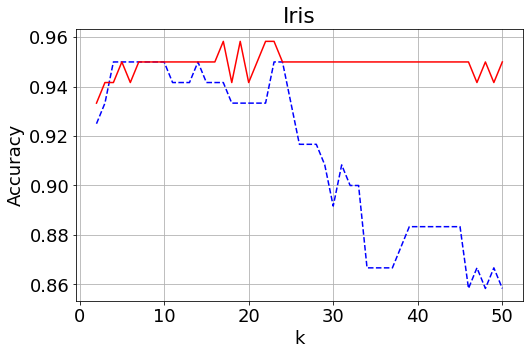

In [35]:
visualize(res_lib_iris, res_mod_iris, title='Iris')

### Pima

In [23]:
pima = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv', 
    delimiter=',', header=None)

In [24]:
pima = pima.to_numpy()
X = pima[:, :-1]
y = pima[:, -1].astype('int')

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((768, 8), (768,))

Text(0.5, 1.0, 'Pima PCA')

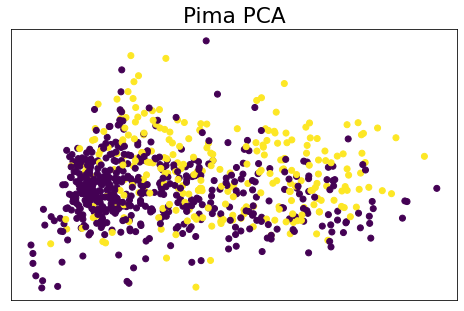

In [25]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 5))
plt.xticks([])
plt.yticks([])

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], c=y)

plt.title("Pima PCA")

In [26]:
best_k_lib_p, best_res_lib_p, test_score_lib_p, res_lib_p = library_knn(X, y)

k = 2 	 validation accuracy = 0.7165400506464081
k = 3 	 validation accuracy = 0.7312941490070639
k = 4 	 validation accuracy = 0.7426762628282021
k = 5 	 validation accuracy = 0.7346261495401839
k = 6 	 validation accuracy = 0.7297347727575637
k = 7 	 validation accuracy = 0.7329868052778888
k = 8 	 validation accuracy = 0.7395041983206717
k = 9 	 validation accuracy = 0.7411302145808343
k = 10 	 validation accuracy = 0.7313607890177262
k = 11 	 validation accuracy = 0.7330001332800213
k = 12 	 validation accuracy = 0.7215913634546182
k = 13 	 validation accuracy = 0.7264827402372385
k = 14 	 validation accuracy = 0.7199653471944556
k = 15 	 validation accuracy = 0.7216046914567507
k = 16 	 validation accuracy = 0.7232440357190457
k = 17 	 validation accuracy = 0.7297481007596961
k = 18 	 validation accuracy = 0.7183526589364254
k = 19 	 validation accuracy = 0.7264960682393709
k = 20 	 validation accuracy = 0.7281220844995334
k = 21 	 validation accuracy = 0.736265493802479
k = 22 	 

In [27]:
best_k_m_p, best_res_m_p, test_score_m_p, res_m_p = manual_knn(X, y)

k = 2 	 validation accuracy = 0.7165400506464081
k = 3 	 validation accuracy = 0.7312941490070639
k = 4 	 validation accuracy = 0.7426762628282021
k = 5 	 validation accuracy = 0.7346261495401839
k = 6 	 validation accuracy = 0.7297347727575637
k = 7 	 validation accuracy = 0.7329868052778888
k = 8 	 validation accuracy = 0.7395041983206717
k = 9 	 validation accuracy = 0.7411302145808343
k = 10 	 validation accuracy = 0.7313607890177262
k = 11 	 validation accuracy = 0.7330001332800213
k = 12 	 validation accuracy = 0.7215913634546182
k = 13 	 validation accuracy = 0.7264827402372385
k = 14 	 validation accuracy = 0.7199653471944556
k = 15 	 validation accuracy = 0.7216046914567507
k = 16 	 validation accuracy = 0.7232440357190457
k = 17 	 validation accuracy = 0.7297481007596961
k = 18 	 validation accuracy = 0.7183526589364254
k = 19 	 validation accuracy = 0.7264960682393709
k = 20 	 validation accuracy = 0.7281220844995334
k = 21 	 validation accuracy = 0.736265493802479
k = 22 	 

In [28]:
best_k_mod_p, best_res_mod_p, test_score_mod_p, res_mod_p = modified_knn(X, y)

k = 2 	 validation accuracy = 0.7035452485672398
k = 3 	 validation accuracy = 0.7117019858723177
k = 4 	 validation accuracy = 0.7198587231773957
k = 5 	 validation accuracy = 0.7361988537918165
k = 6 	 validation accuracy = 0.7264161002265761
k = 7 	 validation accuracy = 0.7345328535252567
k = 8 	 validation accuracy = 0.7296947887511661
k = 9 	 validation accuracy = 0.7443822471011595
k = 10 	 validation accuracy = 0.726469412235106
k = 11 	 validation accuracy = 0.7313474610155938
k = 12 	 validation accuracy = 0.7296947887511662
k = 13 	 validation accuracy = 0.7410902305744369
k = 14 	 validation accuracy = 0.7280421164867387
k = 15 	 validation accuracy = 0.7345994935359189
k = 16 	 validation accuracy = 0.7247900839664134
k = 17 	 validation accuracy = 0.7247634279621484
k = 18 	 validation accuracy = 0.7231640677062509
k = 19 	 validation accuracy = 0.7313074770091963
k = 20 	 validation accuracy = 0.7215247234439558
k = 21 	 validation accuracy = 0.728055444488871
k = 22 	 v

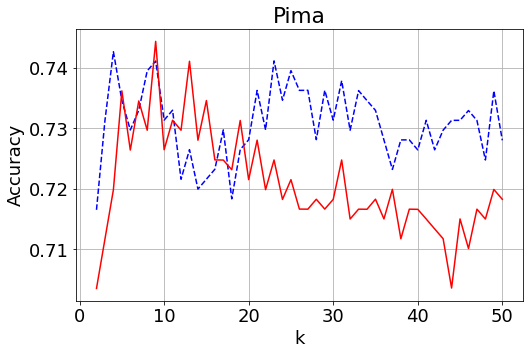

In [31]:
visualize(res_lib_p, res_mod_p, title='Pima')

### Liver

In [98]:
liver = pd.read_csv(
    'https://datahub.io/machine-learning/liver-disorders/r/1.csv', 
    delimiter=',')

In [99]:
liver['selector'] = liver['selector'].replace({2:1, 1:0})

In [100]:
liver = liver.to_numpy()
X = liver[:, :-1]
y = liver[:, -1]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((345, 6), (345,))

Text(0.5, 1.0, 'Liver PCA')

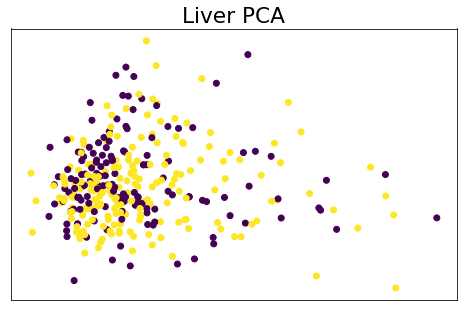

In [40]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 5))
plt.xticks([])
plt.yticks([])

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], c=y)

plt.title("Liver PCA")

In [41]:
best_k_l, best_res_l, test_score_l, res_lib_l = library_knn(X, y)

k = 2 	 validation accuracy = 0.5653896103896103
k = 3 	 validation accuracy = 0.5907142857142856
k = 4 	 validation accuracy = 0.5835714285714285
k = 5 	 validation accuracy = 0.6161688311688311
k = 6 	 validation accuracy = 0.5798701298701299
k = 7 	 validation accuracy = 0.6125324675324675
k = 8 	 validation accuracy = 0.5835714285714285
k = 9 	 validation accuracy = 0.598116883116883
k = 10 	 validation accuracy = 0.6089610389610389
k = 11 	 validation accuracy = 0.6232467532467532
k = 12 	 validation accuracy = 0.5835714285714285
k = 13 	 validation accuracy = 0.6088311688311687
k = 14 	 validation accuracy = 0.587012987012987
k = 15 	 validation accuracy = 0.597987012987013
k = 16 	 validation accuracy = 0.5724675324675325
k = 17 	 validation accuracy = 0.5798701298701299
k = 18 	 validation accuracy = 0.597922077922078
k = 19 	 validation accuracy = 0.615974025974026
k = 20 	 validation accuracy = 0.5869480519480519
k = 21 	 validation accuracy = 0.5944155844155844
k = 22 	 vali

In [42]:
best_k_l, best_res_l, test_score_l, res_m_l = library_knn(X, y)

k = 2 	 validation accuracy = 0.5653896103896103
k = 3 	 validation accuracy = 0.5907142857142856
k = 4 	 validation accuracy = 0.5835714285714285
k = 5 	 validation accuracy = 0.6161688311688311
k = 6 	 validation accuracy = 0.5798701298701299
k = 7 	 validation accuracy = 0.6125324675324675
k = 8 	 validation accuracy = 0.5835714285714285
k = 9 	 validation accuracy = 0.598116883116883
k = 10 	 validation accuracy = 0.6089610389610389
k = 11 	 validation accuracy = 0.6232467532467532
k = 12 	 validation accuracy = 0.5835714285714285
k = 13 	 validation accuracy = 0.6088311688311687
k = 14 	 validation accuracy = 0.587012987012987
k = 15 	 validation accuracy = 0.597987012987013
k = 16 	 validation accuracy = 0.5724675324675325
k = 17 	 validation accuracy = 0.5798701298701299
k = 18 	 validation accuracy = 0.597922077922078
k = 19 	 validation accuracy = 0.615974025974026
k = 20 	 validation accuracy = 0.5869480519480519
k = 21 	 validation accuracy = 0.5944155844155844
k = 22 	 vali

In [43]:
best_k_l, best_res_l, test_score_l, res_mod_l = modified_knn(X, y)

k = 2 	 validation accuracy = 0.5905844155844155
k = 3 	 validation accuracy = 0.5833766233766233
k = 4 	 validation accuracy = 0.5833766233766233
k = 5 	 validation accuracy = 0.6414285714285713
k = 6 	 validation accuracy = 0.638051948051948
k = 7 	 validation accuracy = 0.6126623376623377
k = 8 	 validation accuracy = 0.6126623376623377
k = 9 	 validation accuracy = 0.6305194805194805
k = 10 	 validation accuracy = 0.6051298701298701
k = 11 	 validation accuracy = 0.6268831168831168
k = 12 	 validation accuracy = 0.6122077922077922
k = 13 	 validation accuracy = 0.6269480519480519
k = 14 	 validation accuracy = 0.6268831168831168
k = 15 	 validation accuracy = 0.598116883116883
k = 16 	 validation accuracy = 0.6053896103896104
k = 17 	 validation accuracy = 0.5981168831168832
k = 18 	 validation accuracy = 0.5945454545454545
k = 19 	 validation accuracy = 0.6088961038961039
k = 20 	 validation accuracy = 0.597987012987013
k = 21 	 validation accuracy = 0.5870779220779221
k = 22 	 va

In [101]:
best_k_l, best_res_l, test_score_l, res_mod_l_small = modified_knn(X, y, t=0.4)

k = 2 	 validation accuracy = 0.6194805194805195
k = 3 	 validation accuracy = 0.6123376623376623
k = 4 	 validation accuracy = 0.6231818181818183
k = 5 	 validation accuracy = 0.6413636363636364
k = 6 	 validation accuracy = 0.6486363636363636
k = 7 	 validation accuracy = 0.6377922077922078
k = 8 	 validation accuracy = 0.6342207792207792
k = 9 	 validation accuracy = 0.6377272727272727
k = 10 	 validation accuracy = 0.634090909090909
k = 11 	 validation accuracy = 0.6304545454545455
k = 12 	 validation accuracy = 0.6375974025974026
k = 13 	 validation accuracy = 0.634025974025974
k = 14 	 validation accuracy = 0.6412337662337662
k = 15 	 validation accuracy = 0.6231818181818182
k = 16 	 validation accuracy = 0.6304545454545455
k = 17 	 validation accuracy = 0.6231818181818182
k = 18 	 validation accuracy = 0.6232467532467532
k = 19 	 validation accuracy = 0.6304545454545455
k = 20 	 validation accuracy = 0.6376623376623376
k = 21 	 validation accuracy = 0.6268181818181818
k = 22 	 v

In [102]:
best_k_l, best_res_l, test_score_l, res_mod_l_large = modified_knn(X, y, t=0.9)

k = 2 	 validation accuracy = 0.5725324675324674
k = 3 	 validation accuracy = 0.5761688311688312
k = 4 	 validation accuracy = 0.5907142857142856
k = 5 	 validation accuracy = 0.6559740259740259
k = 6 	 validation accuracy = 0.6381818181818181
k = 7 	 validation accuracy = 0.6163636363636364
k = 8 	 validation accuracy = 0.6199350649350649
k = 9 	 validation accuracy = 0.6305844155844156
k = 10 	 validation accuracy = 0.6014935064935065
k = 11 	 validation accuracy = 0.6196753246753246
k = 12 	 validation accuracy = 0.605
k = 13 	 validation accuracy = 0.6233766233766234
k = 14 	 validation accuracy = 0.6232467532467532
k = 15 	 validation accuracy = 0.5944805194805195
k = 16 	 validation accuracy = 0.5980519480519481
k = 17 	 validation accuracy = 0.5837012987012986
k = 18 	 validation accuracy = 0.5837012987012986
k = 19 	 validation accuracy = 0.6053896103896104
k = 20 	 validation accuracy = 0.598116883116883
k = 21 	 validation accuracy = 0.5872077922077922
k = 22 	 validation ac

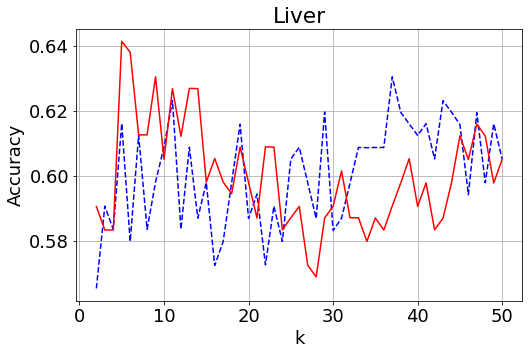

In [44]:
visualize(res_lib_l, res_mod_l, title='Liver')

Text(0, 0.5, 'Accuracy')

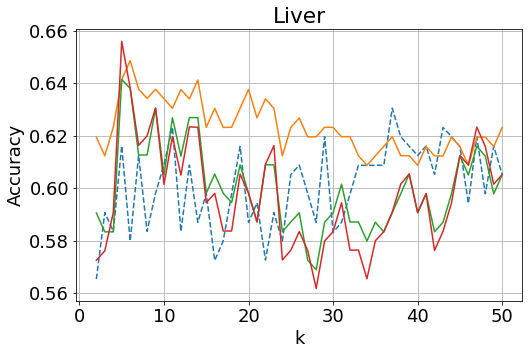

In [106]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(8, 5))

K = [k for k in range(2, 51)]

plt.plot(K, res_lib_l, '--', label='library')
plt.plot(K, res_mod_l_small, label='t=0.4')
plt.plot(K, res_mod_l, label='t=0.7')
plt.plot(K, res_mod_l_large, label='t=0.9')


plt.title('Liver')
plt.grid(True)
plt.xlabel("k")
plt.ylabel("Accuracy")
# plt.legend()

### Sonar

In [10]:
sonar = pd.read_csv(
   os.path.join(path, 'sonar.all-data'), header = None)

In [11]:
sonar[60] = sonar[60].replace({'R':1, 'M':0})

In [12]:
sonar = sonar.to_numpy()
X = sonar[:, :-1]
y = sonar[:, -1]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((208, 60), (208,))

Text(0.5, 1.0, 'Sonar PCA')

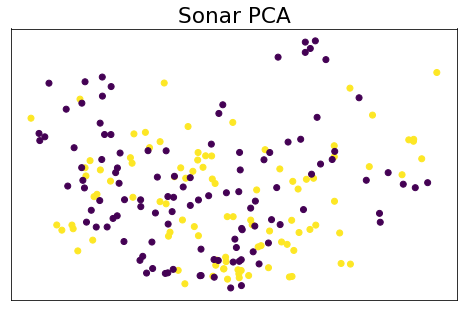

In [49]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 5))
plt.xticks([])
plt.yticks([])

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], c=y)

plt.title("Sonar PCA")

In [13]:
best_k_s, best_res_s, test_score_s, res_lib_s = library_knn(X, y)

k = 2 	 validation accuracy = 0.7590017825311943
k = 3 	 validation accuracy = 0.7887700534759359
k = 4 	 validation accuracy = 0.7588235294117648
k = 5 	 validation accuracy = 0.7463458110516934
k = 6 	 validation accuracy = 0.662210338680927
k = 7 	 validation accuracy = 0.6864527629233512
k = 8 	 validation accuracy = 0.6440285204991086
k = 9 	 validation accuracy = 0.6442067736185383
k = 10 	 validation accuracy = 0.6322638146167557
k = 11 	 validation accuracy = 0.6442067736185383
k = 12 	 validation accuracy = 0.6322638146167557
k = 13 	 validation accuracy = 0.6443850267379678
k = 14 	 validation accuracy = 0.6506238859180036
k = 15 	 validation accuracy = 0.6684491978609625
k = 16 	 validation accuracy = 0.6989304812834224
k = 17 	 validation accuracy = 0.6807486631016042
k = 18 	 validation accuracy = 0.6809269162210339
k = 19 	 validation accuracy = 0.6746880570409981
k = 20 	 validation accuracy = 0.680926916221034
k = 21 	 validation accuracy = 0.6746880570409981
k = 22 	 v

In [51]:
best_k_s, best_res_s, test_score_s, res_lib_s = manual_knn(X, y)

k = 2 	 validation accuracy = 0.7590017825311943
k = 3 	 validation accuracy = 0.7887700534759359
k = 4 	 validation accuracy = 0.7588235294117648
k = 5 	 validation accuracy = 0.7463458110516934
k = 6 	 validation accuracy = 0.662210338680927
k = 7 	 validation accuracy = 0.6864527629233512
k = 8 	 validation accuracy = 0.6440285204991086
k = 9 	 validation accuracy = 0.6442067736185383
k = 10 	 validation accuracy = 0.6322638146167557
k = 11 	 validation accuracy = 0.6442067736185383
k = 12 	 validation accuracy = 0.6322638146167557
k = 13 	 validation accuracy = 0.6443850267379678
k = 14 	 validation accuracy = 0.6506238859180036
k = 15 	 validation accuracy = 0.6684491978609625
k = 16 	 validation accuracy = 0.6989304812834224
k = 17 	 validation accuracy = 0.6807486631016042
k = 18 	 validation accuracy = 0.6809269162210339
k = 19 	 validation accuracy = 0.6746880570409981
k = 20 	 validation accuracy = 0.680926916221034
k = 21 	 validation accuracy = 0.6746880570409981
k = 22 	 v

In [14]:
best_k_s, best_res_s, test_score_s, res_mod_s = modified_knn(X, y)

k = 2 	 validation accuracy = 0.7231729055258467
k = 3 	 validation accuracy = 0.7771836007130126
k = 4 	 validation accuracy = 0.7048128342245988
k = 5 	 validation accuracy = 0.7167557932263815
k = 6 	 validation accuracy = 0.6686274509803921
k = 7 	 validation accuracy = 0.6925133689839573
k = 8 	 validation accuracy = 0.6443850267379678
k = 9 	 validation accuracy = 0.656149732620321
k = 10 	 validation accuracy = 0.6563279857397504
k = 11 	 validation accuracy = 0.6925133689839573
k = 12 	 validation accuracy = 0.6500891265597148
k = 13 	 validation accuracy = 0.6864527629233512
k = 14 	 validation accuracy = 0.6445632798573975
k = 15 	 validation accuracy = 0.6803921568627451
k = 16 	 validation accuracy = 0.6319073083778965
k = 17 	 validation accuracy = 0.6802139037433156
k = 18 	 validation accuracy = 0.5962566844919787
k = 19 	 validation accuracy = 0.6445632798573975
k = 20 	 validation accuracy = 0.6324420677361854
k = 21 	 validation accuracy = 0.662566844919786
k = 22 	 v

In [15]:
best_k_s, best_res_s, test_score_s, res_mod_s_small = modified_knn(X, y, t=0.4)

k = 2 	 validation accuracy = 0.8131907308377897
k = 3 	 validation accuracy = 0.8131907308377897
k = 4 	 validation accuracy = 0.8071301247771835
k = 5 	 validation accuracy = 0.8010695187165776
k = 6 	 validation accuracy = 0.7889483065953654
k = 7 	 validation accuracy = 0.7828877005347594
k = 8 	 validation accuracy = 0.7828877005347594
k = 9 	 validation accuracy = 0.7828877005347594
k = 10 	 validation accuracy = 0.7768270944741533
k = 11 	 validation accuracy = 0.7828877005347594
k = 12 	 validation accuracy = 0.7768270944741533
k = 13 	 validation accuracy = 0.7889483065953654
k = 14 	 validation accuracy = 0.7768270944741533
k = 15 	 validation accuracy = 0.7828877005347594
k = 16 	 validation accuracy = 0.7828877005347594
k = 17 	 validation accuracy = 0.7768270944741533
k = 18 	 validation accuracy = 0.7707664884135472
k = 19 	 validation accuracy = 0.7707664884135472
k = 20 	 validation accuracy = 0.7828877005347594
k = 21 	 validation accuracy = 0.7768270944741533
k = 22 	

In [16]:
best_k_s, best_res_s, test_score_s, res_mod_s_large = modified_knn(X, y, t=0.9)

k = 2 	 validation accuracy = 0.7593582887700535
k = 3 	 validation accuracy = 0.8014260249554368
k = 4 	 validation accuracy = 0.7290552584670232
k = 5 	 validation accuracy = 0.7470588235294118
k = 6 	 validation accuracy = 0.7049910873440284
k = 7 	 validation accuracy = 0.7349376114081997
k = 8 	 validation accuracy = 0.6807486631016042
k = 9 	 validation accuracy = 0.6864527629233511
k = 10 	 validation accuracy = 0.6866310160427807
k = 11 	 validation accuracy = 0.7167557932263815
k = 12 	 validation accuracy = 0.6803921568627451
k = 13 	 validation accuracy = 0.7106951871657754
k = 14 	 validation accuracy = 0.6689839572192513
k = 15 	 validation accuracy = 0.7228163992869876
k = 16 	 validation accuracy = 0.6743315508021389
k = 17 	 validation accuracy = 0.7044563279857398
k = 18 	 validation accuracy = 0.6327985739750446
k = 19 	 validation accuracy = 0.6508021390374331
k = 20 	 validation accuracy = 0.6508021390374331
k = 21 	 validation accuracy = 0.6809269162210339
k = 22 	

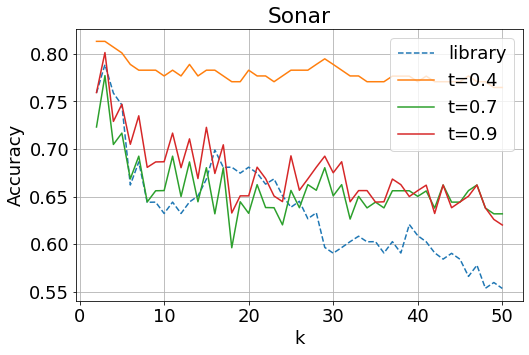

In [18]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(8, 5))

K = [k for k in range(2, 51)]

plt.plot(K, res_lib_s, '--', label='library')
plt.plot(K, res_mod_s_small, label='t=0.4')
plt.plot(K, res_mod_s, label='t=0.7')
plt.plot(K, res_mod_s_large, label='t=0.9')


plt.title('Sonar')
plt.grid(True)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()

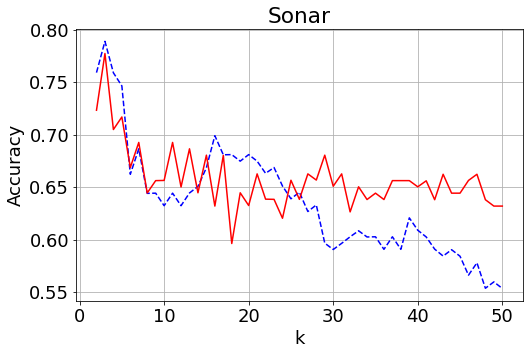

In [54]:
visualize(res_lib_s, res_mod_s, title='Sonar')

### Wheat Seed

In [87]:
ws = pd.read_csv(os.path.join(path, 'seeds_dataset.txt'), delim_whitespace=True, header=None)

In [88]:
ws[7] = ws[7].replace({1:0, 2:1, 3:2})
ws = np.array(ws)

In [89]:
X = ws[:,:-1]
y = ws[:,-1].astype('int')

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((210, 7), (210,))

Text(0.5, 1.0, 'Wheat Seed PCA')

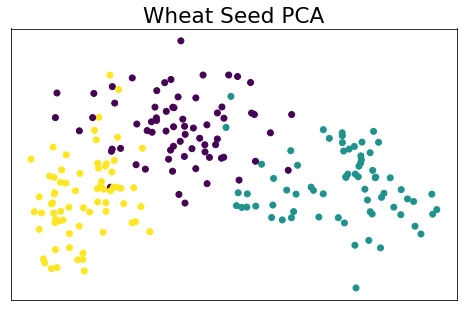

In [58]:
from sklearn.decomposition import PCA

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 5))
plt.xticks([])
plt.yticks([])

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

plt.scatter(new_X[:,0], new_X[:,1], c=y)

plt.title("Wheat Seed PCA")

In [59]:
best_k_ws, best_res_ws, test_score_ws, res_lib_ws = library_knn(X,y)

k = 2 	 validation accuracy = 0.9347593582887701
k = 3 	 validation accuracy = 0.9408199643493761
k = 4 	 validation accuracy = 0.9586452762923351
k = 5 	 validation accuracy = 0.9641711229946524
k = 6 	 validation accuracy = 0.9408199643493761
k = 7 	 validation accuracy = 0.9406417112299466
k = 8 	 validation accuracy = 0.9406417112299466
k = 9 	 validation accuracy = 0.910873440285205
k = 10 	 validation accuracy = 0.9347593582887701
k = 11 	 validation accuracy = 0.9228163992869876
k = 12 	 validation accuracy = 0.9349376114081996
k = 13 	 validation accuracy = 0.9229946524064172
k = 14 	 validation accuracy = 0.9290552584670232
k = 15 	 validation accuracy = 0.9169340463458109
k = 16 	 validation accuracy = 0.9169340463458109
k = 17 	 validation accuracy = 0.9226381461675579
k = 18 	 validation accuracy = 0.9048128342245988
k = 19 	 validation accuracy = 0.9226381461675579
k = 20 	 validation accuracy = 0.9228163992869876
k = 21 	 validation accuracy = 0.9226381461675579
k = 22 	 

In [60]:
best_k_ws, best_res_ws, test_score_ws, res_m_ws = manual_knn(X,y)

k = 2 	 validation accuracy = 0.9347593582887701
k = 3 	 validation accuracy = 0.9408199643493761
k = 4 	 validation accuracy = 0.9586452762923351
k = 5 	 validation accuracy = 0.9641711229946524
k = 6 	 validation accuracy = 0.9408199643493761
k = 7 	 validation accuracy = 0.9406417112299466
k = 8 	 validation accuracy = 0.9406417112299466
k = 9 	 validation accuracy = 0.910873440285205
k = 10 	 validation accuracy = 0.9347593582887701
k = 11 	 validation accuracy = 0.9228163992869876
k = 12 	 validation accuracy = 0.9349376114081996
k = 13 	 validation accuracy = 0.9229946524064172
k = 14 	 validation accuracy = 0.9290552584670232
k = 15 	 validation accuracy = 0.9169340463458109
k = 16 	 validation accuracy = 0.9169340463458109
k = 17 	 validation accuracy = 0.9226381461675579
k = 18 	 validation accuracy = 0.9048128342245988
k = 19 	 validation accuracy = 0.9226381461675579
k = 20 	 validation accuracy = 0.9228163992869876
k = 21 	 validation accuracy = 0.9226381461675579
k = 22 	 

In [91]:
best_k_ws, best_res_ws, test_score_ws, res_mod_ws = modified_knn(X,y)

k = 2 	 validation accuracy = 0.905169340463458
k = 3 	 validation accuracy = 0.9229946524064172
k = 4 	 validation accuracy = 0.9228163992869876
k = 5 	 validation accuracy = 0.9288770053475937
k = 6 	 validation accuracy = 0.928698752228164
k = 7 	 validation accuracy = 0.9406417112299466
k = 8 	 validation accuracy = 0.946524064171123
k = 9 	 validation accuracy = 0.9347593582887701
k = 10 	 validation accuracy = 0.946524064171123
k = 11 	 validation accuracy = 0.9406417112299466
k = 12 	 validation accuracy = 0.9404634581105169
k = 13 	 validation accuracy = 0.9404634581105169
k = 14 	 validation accuracy = 0.9404634581105169
k = 15 	 validation accuracy = 0.9345811051693405
k = 16 	 validation accuracy = 0.9345811051693405
k = 17 	 validation accuracy = 0.9345811051693405
k = 18 	 validation accuracy = 0.9345811051693405
k = 19 	 validation accuracy = 0.9345811051693405
k = 20 	 validation accuracy = 0.928698752228164
k = 21 	 validation accuracy = 0.9345811051693405
k = 22 	 vali

In [92]:
best_k_ws, best_res_ws, test_score_ws, res_mod_ws_small = modified_knn(X, y, t=0.4)

k = 2 	 validation accuracy = 0.905169340463458
k = 3 	 validation accuracy = 0.905169340463458
k = 4 	 validation accuracy = 0.9110516934046344
k = 5 	 validation accuracy = 0.9171122994652408
k = 6 	 validation accuracy = 0.9110516934046344
k = 7 	 validation accuracy = 0.9171122994652408
k = 8 	 validation accuracy = 0.9229946524064172
k = 9 	 validation accuracy = 0.9171122994652408
k = 10 	 validation accuracy = 0.9229946524064172
k = 11 	 validation accuracy = 0.9171122994652408
k = 12 	 validation accuracy = 0.9169340463458111
k = 13 	 validation accuracy = 0.9169340463458111
k = 14 	 validation accuracy = 0.9169340463458111
k = 15 	 validation accuracy = 0.9110516934046344
k = 16 	 validation accuracy = 0.9110516934046344
k = 17 	 validation accuracy = 0.9110516934046344
k = 18 	 validation accuracy = 0.9110516934046344
k = 19 	 validation accuracy = 0.9110516934046344
k = 20 	 validation accuracy = 0.9110516934046344
k = 21 	 validation accuracy = 0.9110516934046344
k = 22 	 v

In [93]:
best_k_ws, best_res_ws, test_score_ws, res_mod_ws_large = modified_knn(X,y, t=0.9)

k = 2 	 validation accuracy = 0.8992869875222815
k = 3 	 validation accuracy = 0.9229946524064172
k = 4 	 validation accuracy = 0.9228163992869876
k = 5 	 validation accuracy = 0.9288770053475937
k = 6 	 validation accuracy = 0.928698752228164
k = 7 	 validation accuracy = 0.9406417112299466
k = 8 	 validation accuracy = 0.946524064171123
k = 9 	 validation accuracy = 0.9347593582887701
k = 10 	 validation accuracy = 0.946524064171123
k = 11 	 validation accuracy = 0.9406417112299466
k = 12 	 validation accuracy = 0.9345811051693405
k = 13 	 validation accuracy = 0.9345811051693405
k = 14 	 validation accuracy = 0.9345811051693405
k = 15 	 validation accuracy = 0.928698752228164
k = 16 	 validation accuracy = 0.928698752228164
k = 17 	 validation accuracy = 0.9345811051693405
k = 18 	 validation accuracy = 0.928698752228164
k = 19 	 validation accuracy = 0.928698752228164
k = 20 	 validation accuracy = 0.9228163992869876
k = 21 	 validation accuracy = 0.928698752228164
k = 22 	 validat

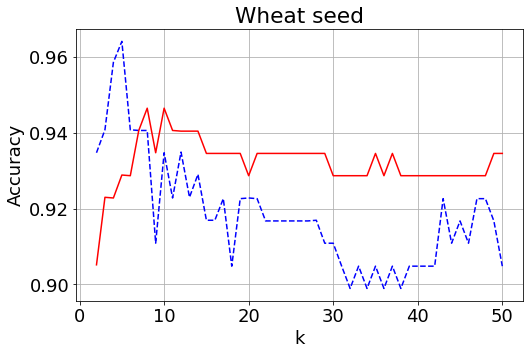

In [107]:
visualize(res_lib_ws, res_mod_ws, title='Wheat seed')

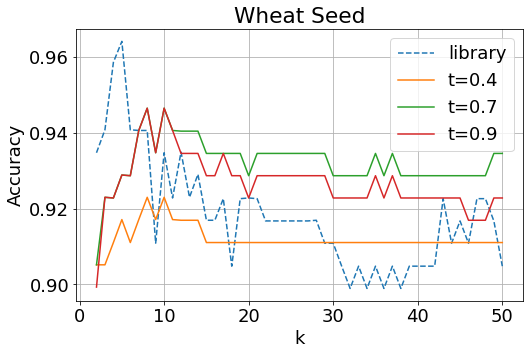

In [103]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(8, 5))

K = [k for k in range(2, 51)]

plt.plot(K, res_lib_ws, '--', label='library')
plt.plot(K, res_mod_ws_small, label='t=0.4')
plt.plot(K, res_mod_ws, label='t=0.7')
plt.plot(K, res_mod_ws_large, label='t=0.9')


plt.title("Wheat Seed")
plt.grid(True)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()